# Lab 2 - Leveraging SpaCy for Comparative Textual EDA (Part 1)

In the last lab you learned about:
- spaCy's Doc object structure
- Token attributes (text, pos_, lemma_, is_stop, is_punct)
- Using the spaCy pipeline for tokenization, lemmatization, POS tagging, Parsing, and NER
- Iterating over tokens to extract linguistic features
- Exploring differences between classical NLP methods and LLM-based methods

**Learning objectives this week:**

- **Conduct a small comparative corpus analysis**, recognizing how sampling decisions, labeling, and preprocessing choices affect downstream analysis.
- **Apply spaCy to exploratory text analysis**, using token and word counts.
- **Use frequency, normalization, and dispersion** to compare language use across groups, and explain why raw counts are often misleading.
- **Interpret lexical variety through lemmatization**, including calculating and reasoning about lemma–token ratios and shared vs. group-specific vocabulary.

**Useful References:**

- SpaCy API. https://spacy.io/api
- Jurafsky and Martin, [Chapter 2 ](https://web.stanford.edu/~jurafsky/slp3/2.pdf): Words and Tokens

We're speeding ahead into EDA early because your mid-term project will be EDA. This lab and the next are rather long and go into much more depth than necessary for that assignment. However, it will help you to start thinking about this earlier, rather than later.

In [ ]:
# If you are colab, un-comment the pip install below.
# This will not be necessary on DeepNote or your local installation

#!pip install data401_nlp

## Load libraries and models

In [ ]:
#| eval: false

# Environment (must run first)
from dotenv import load_dotenv

import data401_nlp
print(data401_nlp.__version__)

# Core libs
import os
import re
from collections import Counter

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math

import spacy

0.0.6


0.0.6


0.0.7


In [ ]:
#| eval: false

# This checks to make sure your SUBMIT_API_KEY is present
# It can take a moment to load... run again if it fails the first time

env = load_env()
print("Detected environment:", env)
print("SUBMIT_API_KEY present:", bool(os.getenv("SUBMIT_API_KEY")))

Detected environment: dotenv
SUBMIT_API_KEY present: True


## Introduction to Corpus Design and EDA

In traditional corpus linguistics, the word **corpus** refers to a sample of language data that strives to be representative of a particular language variety. **Language variety** is a general term for language that shares one or more common traits, such as dialect, genre, or topic.

In this week's classroom activity, you will examine corpora designed to study distributional properties of language. Such corpora are sampled with careful tracking of demographic and linguistic representativeness. They are also labeled with high-quality annotations to capture linguistic features of interest. This sampling and annotation allows for reproducible, high-confidence analyses. 

That said, designed corpora come with a great amount of exploratory data analysis already included in metadata. For example, often included are descriptive statistics such as number of sentences, words, etc. Thus today, you will do EDA with basic statistics and analysis using spaCy. 

Next week you will use NLP techniques such as parsing, pattern recognition, and named entity recognition to infer labels and describe and compare two sets of related data. What you won't do at this point is assess the accuracy of your labeling. 

### The Purpose of EDA

**Exploratory Data Analysis (EDA)** is the process of examining and summarizing datasets to understand their main characteristics before applying formal modeling or hypothesis testing. For text data, EDA involves understanding vocabulary, document lengths, word distributions, and linguistic patterns.

Data collection and analysis serve one goal: answering questions with data. With that in mind, EDA serves a few purposes:
1. Ensure **representativeness** of the population or phenomenon under consideration
    - to make sure that the phenomena you seek are present in the data
    - to identify and account for outliers or other anomalies
2. Reveal **characteristics of data** that might affect the **generalizability** or **validity** of your analysis
3. Provide insight into **features** that can be helpful in answering your data analytic questions

### Questions to Kick-off EDA

You can start an EDA by asking some fundamental questions, such as:
- How can I make sure my data is **representative** of the people or phenomena I want to describe?
- Do I have **enough data**?
    - e.g., if using a sentiment lexicon, do the words in the lexicon appear often enough to provide a basis for analysis
- What is the **structure of my data**?
    - threaded conversation-like discourse with identifiable speakers
        - Do I have enough information about the speakers to generalize about them?
        - Do I have enough text per speaker?
    - news articles that all start with a summary of new information
    - academic literature with a keyword list and abstract
    - sports reports where I might find tables with statistics
- What **metadata** is available?
    - user profiles with demographic information
    - topic lists
    - hashtags that might act like topic or discourse labels
- What **useful features can be derived** from the data?
    - would grouping the data into topics make sense?
    - do I need to extract person names or @mentions to answer the question at hand?

## Quick Refresher

Let's load our dataset into doc objects

In [ ]:
#| eval: false

from data401_nlp.helpers.spacy import ensure_spacy_model

def get_nlp():
    return ensure_spacy_model("en_core_web_sm")
    
nlp = get_nlp()

df1 = pd.read_csv("data/covidisreal_OR_wearamask_hashtag.csv")
df2 = pd.read_csv("data/covidhoax_OR_notomasks_hashtag.csv")

df1['group'] = 'promask'
df2['group'] = 'antimask'
df = pd.concat([df1, df2], ignore_index=True)
df.groupby('group').head(4)

✅ spaCy model 'en_core_web_sm' loaded successfully


,created_date,hashtags,num_hashtags,tweet_length,tweet_text,group
0,2020-08-31 02:08:31,2020sucks trumpisscar ihateithere wearamask,4,90,#2020sucks #trumpisscar #ihateithere #wearamas...,promask
1,2020-08-31 02:07:58,antimasker antimasking DOJ pandemic,4,137,This is probably one of the most ridiculous of...,promask
2,2020-08-31 02:07:28,wearamask maskuphoosiers,2,69,"Just, like, do it. #wearamask #maskuphoosiers ...",promask
3,2020-08-31 02:07:16,NaN,0,140,So one day a guy will be bragging how he didn’...,promask
5000,2020-08-31 02:03:58,COVID19 covidhoax,2,125,6% Of all #COVID19 Deaths were from just the v...,antimask
5001,2020-08-31 02:03:35,COVID19,1,140,#COVID19 is a hoax. Fuck masks. If you don’t ...,antimask
5002,2020-08-31 02:02:55,COVID19 CovidHoax,2,148,@ProfPCDoherty There was no need to shut the b...,antimask
5003,2020-08-31 02:01:45,CovidHoax,1,140,#CovidHoax is over... Let's OPEN the world and...,antimask


In Lab 1, we processed individual sentences. Today: what happens when we process thousands of tweets and compare patterns across two communities?

## Corpus-Level Overview

### Dataset Description

### Introduction 

Our goal for this lab is to do exploratory data analysis on a collection from Twitter.

Your dataset is comprised of two CSV files. They were both collected in 2020 using [Tweepy](https://www.tweepy.org/), a Python library for accessing Twitter's API. Two searches were conducted, with a maximum number of English language tweets of 5000, and with retweets filtered out during collection.

Hashtags used for search were:
1. #covidhoax OR #notomask
2. #covidisreal OR #wearamask

This collection was created specifically for students of NLP in a prior semester. The data is not representative of any population and is not intended for publication or re-distribution. 

We will explore and describe this dataset using descriptive statistics first. Then we will compare the two collections using other spaCy capabilities.

Please do not share or post these CSV files. Despite changes in Twitter ownership, they come with licensing restrictions. In the past, I had students collect this data individually. Since that's no longer an easy option, you will use pre-collected data. The [licensing restriction applicable to the 2020 collection is documented here](https://github.com/KatherineMichel/stanford-code-in-place-final-project/blob/master/twitter-developer-agreement-march-10.md). 

> You may not "sell, rent, lease, sublicense, distribute, redistribute, syndicate… or otherwise transfer or provide access to… the Licensed Material to any third party except as expressly permitted," which means you should not give students a large raw dump designed to let them avoid having their own relationship with the API.

> In practice, for a small academic exercise: it is acceptable to share a modest tweet subset with students inside your course context, provided it is non‑commercial, secured, not a bulk replacement for the API, and you honor deletion/visibility changes and the privacy and usage rules in the Developer Policy.


## A - Token-Level Distributions

We'll start with basic descriptive statistics. In particular, we're interested in:

- hashtag counts
- token counts
- word length
- tweets (documents)
- and tweet (document) length.

Let's take a step back and think about what we are counting when we talk about tokens.

We already know **tokens** are a basic unit of processing—individual instances of words, punctuation, or other text elements as they appear in a document. A **type** is a distinct word form; it represents the unique vocabulary item regardless of how many times it appears. In fact, we often think of words as canonical tokens.

> **Key distinction:** If a document contains "the cat and the dog," it has 5 tokens but only 4 types (since "the" appears twice).

From [spaCy documentation](https://spacy.io/api/lexeme):

- In spaCy, a **lexeme** is a *vocabulary entry* keyed by the hash of a string form (ORTH), representing a word type (form) with context‑independent attributes like casing, shape, and optional vector, but no token-level context such as POS or dependency.
- In spaCy, **a lexeme is "a word type, as opposed to a word token,"** stored in Vocab and shared by all tokens with the same ORTH (string hash).
- spaCy maintains a StringStore mapping each distinct string to a unique integer ID; the same ID (ORTH) is used to index a Lexeme in Vocab.
- When a new string appears (e.g., during tokenization or when you access nlp.vocab["word"]), spaCy creates or retrieves the corresponding lexeme keyed by that ORTH value.

While there are lots of ways to think about vocabulary and count things, you should always be careful to explain how you counted. In the function below, we are counting objects that:
- have already been pre-processed
- are lower-cased
- are not whitespace characters.

**`get_vocab()`** (below) is a function builds a vocabulary set by iterating through all texts, processing each through spaCy's pipeline, extracting each token's lowercase text, and filtering out whitespace. The result is the set of unique word forms (types) in the corpus.

In [ ]:
#| eval: false

def get_vocab(texts, nlp):
    """Return set of unique lowercased token strings from texts."""
    if hasattr(texts, "tolist"):
        texts = texts.tolist()
    return {
        tok.text.lower()
        for doc in nlp.pipe((t for t in texts if isinstance(t, str)))
        for tok in doc
        if not tok.is_space
    }

nlp = get_nlp()  # if you want this cell to be standalone
promask_vocab = get_vocab(df.loc[df.group == "promask", "tweet_text"], nlp)
antimask_vocab = get_vocab(df.loc[df.group == "antimask", "tweet_text"], nlp)
combined_vocab = promask_vocab | antimask_vocab

dict(
    promask=len(promask_vocab),
    antimask=len(antimask_vocab),
    combined=len(combined_vocab),
    shared=len(promask_vocab & antimask_vocab),
)


✅ spaCy model 'en_core_web_sm' loaded successfully


{'promask': 17753, 'antimask': 8293, 'combined': 22939, 'shared': 3107}

**`compute_token_counts():`** counts the number of tokens in each document by processing texts through spaCy and returning the length of each resulting Doc object.

In [ ]:
#| eval: false

def compute_token_counts(texts):
    nlp = get_nlp()
    if hasattr(texts, "tolist"):
        texts = texts.tolist()
    return [
        len(doc)
        for doc in nlp.pipe((t for t in texts if isinstance(t, str)))
    ]

df["token_count"] = compute_token_counts(df["tweet_text"])
df["token_count"]

✅ spaCy model 'en_core_web_sm' loaded successfully


0       13
1       23
2       12
3       29
4       25
        ..
7064    31
7065    23
7066    22
7067    28
7068    24
Name: token_count, Length: 7069, dtype: int64

Let's check for missing data.

In [ ]:
#| eval: false

missing = df[['created_date', 'hashtags', 'num_hashtags', 'tweet_length', 'tweet_text', 'group']].isnull().sum()
missing

created_date       0
hashtags        2419
num_hashtags       0
tweet_length       0
tweet_text         0
group              0
dtype: int64

We might not care if hashtags are missing, though it is interesting that such a large number of tweets don't contain them. What do you think the absense of hashtags might indicate?

In [ ]:
#| eval: false

df[df.duplicated(subset='tweet_text', keep=False)].sort_values('tweet_text').head(10)

,created_date,hashtags,num_hashtags,tweet_length,tweet_text,group,token_count
5759,2020-08-27 19:36:10,COVID CovidHoax,2,121,@cangal21 Forced quarantine camps now operatin...,antimask,22
5756,2020-08-27 19:37:56,COVID CovidHoax,2,121,@cangal21 Forced quarantine camps now operatin...,antimask,22
5489,2020-08-29 04:32:47,masksavelives wearamask masksoff,3,138,@jadedcreative Yes everyone please virtue-sign...,antimask,28
3532,2020-08-29 04:32:47,masksavelives wearamask masksoff,3,138,@jadedcreative Yes everyone please virtue-sign...,promask,28
5484,2020-08-29 05:48:42,NaN,0,140,@letseathh @BBCNews Can you please explain to ...,antimask,24
3476,2020-08-29 05:48:42,NaN,0,140,@letseathh @BBCNews Can you please explain to ...,promask,24
5488,2020-08-29 04:42:07,masksavelives wearamask masksoff covid coronav...,5,136,@markpoloncarz VIRTUE-SIGNALING DOES NOT SAVE ...,antimask,24
3528,2020-08-29 04:42:07,masksavelives wearamask masksoff covid coronav...,5,136,@markpoloncarz VIRTUE-SIGNALING DOES NOT SAVE ...,promask,24
5768,2020-08-27 19:32:30,COVID CovidHoax,2,127,@roccogalatilaw Forced quarantine camps now op...,antimask,22
5762,2020-08-27 19:35:14,COVID CovidHoax,2,127,@roccogalatilaw Forced quarantine camps now op...,antimask,22


In [ ]:
#| eval: false

n_duplicates = df.duplicated(subset='tweet_text').sum()
n_duplicates

np.int64(17)

Based on the duplicate examples shown, some may be tweets that matched both search queries (e.g., a tweet containing both #wearamask and #covidhoax hashtags). Since the two CSV files were collected separately using different hashtag searches, the same tweet could appear in both collections.

Let's start looking at tokens! Let's add a column that shows us tokenization with a simple split function. Recall that **spaCy's tokenizer handles punctuation, contractions, URLs, etc. as separate tokens, while split() just breaks on spaces**. Let's compare these two approaches with our data.

In [ ]:
#| eval: false

def compute_split_counts(texts):
    if hasattr(texts, "tolist"):
        texts = texts.tolist()
    return [len(t.split()) if isinstance(t, str) else 0 for t in texts]

df["split_count"] = compute_split_counts(df["tweet_text"])

df.groupby("group").head(3)

,created_date,hashtags,num_hashtags,tweet_length,tweet_text,group,token_count,split_count
0,2020-08-31 02:08:31,2020sucks trumpisscar ihateithere wearamask,4,90,#2020sucks #trumpisscar #ihateithere #wearamas...,promask,13,9
1,2020-08-31 02:07:58,antimasker antimasking DOJ pandemic,4,137,This is probably one of the most ridiculous of...,promask,23,18
2,2020-08-31 02:07:28,wearamask maskuphoosiers,2,69,"Just, like, do it. #wearamask #maskuphoosiers ...",promask,12,7
5000,2020-08-31 02:03:58,COVID19 covidhoax,2,125,6% Of all #COVID19 Deaths were from just the v...,antimask,30,23
5001,2020-08-31 02:03:35,COVID19,1,140,#COVID19 is a hoax. Fuck masks. If you don’t ...,antimask,34,25
5002,2020-08-31 02:02:55,COVID19 CovidHoax,2,148,@ProfPCDoherty There was no need to shut the b...,antimask,31,23


Let's grab one of these datasets and compare split() with spaCy tokenization by eyeballing a few tweets.

In [ ]:
#| eval: false

nlp = get_nlp()

for i in range(3):
    text = df["tweet_text"].iloc[i]
    doc = nlp(text)
    print(f"Tweet {i}:")
    print(f"  split(): {text.split()}")
    print(f"  spaCy: {[tok.text for tok in doc]}")
    print()

✅ spaCy model 'en_core_web_sm' loaded successfully
Tweet 0:
  split(): ['#2020sucks', '#trumpisscar', '#ihateithere', '#wearamask', '@', 'Black', 'In', 'America', 'https://t.co/0xJHTodSHO']
  spaCy: ['#', '2020sucks', '#', 'trumpisscar', '#', 'ihateithere', '#', 'wearamask', '@', 'Black', 'In', 'America', 'https://t.co/0xJHTodSHO']

Tweet 1:
  split(): ['This', 'is', 'probably', 'one', 'of', 'the', 'most', 'ridiculous', 'of', 'all', '#antimasker', '#antimasking', 'excuses', 'ever', 'recorded', '#DOJ', '#pandemic…', 'https://t.co/LQ53BRJVfI']
  spaCy: ['This', 'is', 'probably', 'one', 'of', 'the', 'most', 'ridiculous', 'of', 'all', '#', 'antimasker', '#', 'antimasking', 'excuses', 'ever', 'recorded', '#', 'DOJ', '#', 'pandemic', '…', 'https://t.co/LQ53BRJVfI']

Tweet 2:
  split(): ['Just,', 'like,', 'do', 'it.', '#wearamask', '#maskuphoosiers', 'https://t.co/uaVHCyWnu2']
  spaCy: ['Just', ',', 'like', ',', 'do', 'it', '.', '#', 'wearamask', '#', 'maskuphoosiers', 'https://t.co/uaVHCyWnu

Aaack! We want to keep our hashtags together! We need to look more carefully to see what else might be a problem.


Here's a fake tweet with a variety of text processing issues. 

```python
test_tweet = "OMG @DrFauci said #WearAMask!!! 😷🔥 But my café au lait ☕ costs $3.50... Can't breathe w/ masks 🙄 #COVID19 #NoToMasks https://t.co/fake123 RT: \"stay safe\" 👏👏👏 naïve ppl don't get it 😤"
```

This includes:
- @mentions and #hashtags
- Emoji (😷🔥☕🙄😤👏)
- Accented characters (café, naïve)
- Punctuation clusters (!!!, ...)
- Contractions (Can't)
- Currency ($3.50)
- URLs
- Quoted text
- Abbreviations (RT, OMG, ppl, w/)

Try running it through spaCy and `split()` to see how each handles these!

In [ ]:
#| eval: false

test_tweet = "OMG @DrFauci said #WearAMask!!! 😷🔥 But my café au lait ☕ costs $3.50... Can't breathe w/ masks 🙄 #COVID19 #NoToMasks https://t.co/fake123 RT: \"stay safe\" 👏👏👏 naïve ppl don't get it 😤"

In [ ]:
#| eval: false

test_tweet.split()

['OMG',
 '@DrFauci',
 'said',
 '#WearAMask!!!',
 '😷🔥',
 'But',
 'my',
 'café',
 'au',
 'lait',
 '☕',
 'costs',
 '$3.50...',
 "Can't",
 'breathe',
 'w/',
 'masks',
 '🙄',
 '#COVID19',
 '#NoToMasks',
 'https://t.co/fake123',
 'RT:',
 '"stay',
 'safe"',
 '👏👏👏',
 'naïve',
 'ppl',
 "don't",
 'get',
 'it',
 '😤']

In [ ]:
#| eval: false

nlp = get_nlp()
test_doc = nlp(test_tweet)
[word.text for word in test_doc]

✅ spaCy model 'en_core_web_sm' loaded successfully


['OMG',
 '@DrFauci',
 'said',
 '#',
 'WearAMask',
 '!',
 '!',
 '!',
 '😷',
 '🔥',
 'But',
 'my',
 'café',
 'au',
 'lait',
 '☕',
 'costs',
 '$',
 '3.50',
 '...',
 'Ca',
 "n't",
 'breathe',
 'w/',
 'masks',
 '🙄',
 '#',
 'COVID19',
 '#',
 'NoToMasks',
 'https://t.co/fake123',
 'RT',
 ':',
 '"',
 'stay',
 'safe',
 '"',
 '👏',
 '👏',
 '👏',
 'naïve',
 'ppl',
 'do',
 "n't",
 'get',
 'it',
 '😤']

Look through these carefully. What do you see beyond hashtags?

Here are some ideas for examining differences in tokenization:


1. **Systematic comparison** — Find all tweets where `split()` and spaCy token counts differ significantly, then examine those cases

2. **Use spaCy's token attributes** — Check `token.is_punct`, `token.like_url`, `token.like_num`, etc. to see how spaCy is classifying things

3. **Look at the spaCy docs** — They document known tokenization behaviors and special cases

4. **Sample randomly** — Instead of crafting a test tweet, grab random real tweets and inspect them

Let's pick the data-driven approach to look at documents that vary dramatically in token counts.

In [ ]:
#| eval: false

required_cols = {"token_count", "split_count"}
missing = required_cols - set(df.columns)
if missing:
    raise ValueError(f"Missing required columns: {missing}")

df["token_diff"] = df["token_count"] - df["split_count"]
df.sort_values("token_diff", ascending=False).head(20)


,created_date,hashtags,num_hashtags,tweet_length,tweet_text,group,token_count,split_count,token_diff
498,2020-08-30 20:44:33,starwars darthvader vader mask helmet,5,140,Dude... just wear a mask\n.\n.\n.\n___________...,promask,67,15,52
1985,2020-08-29 23:42:00,wearamask mask safe health healthy behappy fac...,8,140,Ladies ❤️👱‍♀️👩🏽‍🦰👩🏿‍🦰👩‍🦱👩‍🦳👩👩🏾❤️\n\n❤️😷🙏😷❤️\n#...,promask,51,12,39
4702,2020-08-28 17:21:14,NaN,0,140,My daily internal monologue: \n\n...it-goes-ov...,promask,44,6,38
4063,2020-08-28 22:36:46,WearAMask CutenessOverload doubleshotoflove,3,131,🐱⛱☀️⛱☀️🐱☀️⛱☀️⛱🐱\n⛱Double Weekend Cuteness⛱\n🐱⛱...,promask,47,9,38
975,2020-08-30 16:01:10,NaN,0,129,"IT’S NATIONAL BEACH DAY!!!🌊\nHave sun, have fu...",promask,52,16,36
6700,2020-08-23 18:49:14,trump IvankaTrumpCoffins jina maga kag aAynOB1...,8,138,#trump 🤡🎈🇷🇺🍑🍑🤦🤦‍♂️🌴🥥 \n#IvankaTrumpCoffins⚰️⚰️...,antimask,44,13,31
4684,2020-08-28 17:27:30,NaN,0,134,"""How Many😷😷😷Masks Can Ya Count in Last Night’s...",promask,38,14,24
2868,2020-08-29 15:26:32,playlist QuarantineLife WearAMask,3,129,Laleh - Some Die Young 🕊🕊🕊\n https://t.co/CJn...,promask,37,15,22
1021,2020-08-30 15:41:19,wearamaskchallenge WearAMask TrumpsAmerica,3,114,Another Trump MAGAt. 🙄M~E~L~T~D~O~W~N #wearama...,promask,32,10,22
6792,2020-08-23 12:46:45,CovidHoax scamdemic,2,108,"Have you heard this?? ""we're all gonna die"" LM...",antimask,34,12,22


In [ ]:
#| eval: false

# Uncomment to view data in a spreadsheet
#df.to_csv("tweets_with_tokens.csv", index=False)

We've sorted to look where the two methods have few differences and those with many. What patterns do you notice? Look through examples and jot down your observations. 

You can also export to a csv to make it easier to view your data.

#### Modify tokenization

It turns out that **if you want to pre-process data before it hits the tokenizer, you need to process that data before it hits the spacy pipeline**. We may or may not want to use this function, but I've created one to do this and have added a "clean_text" column to our dataframe. Some best practices are:

- Don't ever delete the original data
- Save every version you create and document what you've done (notebooks are very handy for this!)
- Don't get so tunnel visioned that you don't question you need to back-track and modify assumptions later
- 

In [ ]:
#| eval: false

def clean_text(text):
    if not isinstance(text, str):
        return ""
    return text.lower().replace("\n", " ")

def process_tweet(text):
    nlp = get_nlp()
    return nlp(clean_text(text))

In [ ]:
#| eval: false

process_tweet(test_tweet)

✅ spaCy model 'en_core_web_sm' loaded successfully


omg @drfauci said #wearamask!!! 😷🔥 but my café au lait ☕ costs $3.50... can't breathe w/ masks 🙄 #covid19 #notomasks https://t.co/fake123 rt: "stay safe" 👏👏👏 naïve ppl don't get it 😤

In [ ]:
#| eval: false
df["clean_text"] = df["tweet_text"].apply(clean_text)

In [ ]:
#| eval: false
df.groupby('group').head(3)

,created_date,hashtags,num_hashtags,tweet_length,tweet_text,group,token_count,split_count,token_diff,clean_text
0,2020-08-31 02:08:31,2020sucks trumpisscar ihateithere wearamask,4,90,#2020sucks #trumpisscar #ihateithere #wearamas...,promask,13,9,4,#2020sucks #trumpisscar #ihateithere #wearamas...
1,2020-08-31 02:07:58,antimasker antimasking DOJ pandemic,4,137,This is probably one of the most ridiculous of...,promask,23,18,5,this is probably one of the most ridiculous of...
2,2020-08-31 02:07:28,wearamask maskuphoosiers,2,69,"Just, like, do it. #wearamask #maskuphoosiers ...",promask,12,7,5,"just, like, do it. #wearamask #maskuphoosiers ..."
5000,2020-08-31 02:03:58,COVID19 covidhoax,2,125,6% Of all #COVID19 Deaths were from just the v...,antimask,30,23,7,6% of all #covid19 deaths were from just the v...
5001,2020-08-31 02:03:35,COVID19,1,140,#COVID19 is a hoax. Fuck masks. If you don’t ...,antimask,34,25,9,#covid19 is a hoax. fuck masks. if you don’t ...
5002,2020-08-31 02:02:55,COVID19 CovidHoax,2,148,@ProfPCDoherty There was no need to shut the b...,antimask,31,23,8,@profpcdoherty there was no need to shut the b...


Now we want to adjust tokenization to leave the "#" connected to the hashtag. 

**How the spaCy tokenizer works:**

The spaCy tokenizer follows a three-step process:
1. First, the tokenizer splits the text on whitespace similar to the split() function.
2. Then the tokenizer checks whether the substring matches the tokenizer exception rules. For example, "don't" does not contain whitespace, but should be split into two tokens, "do" and "n't", while "N.Y." should remain one token.
3. Then, it checks for a prefix, suffix, or infix in a substring; these include commas, periods, hyphens, or quotes. If it matches, the substring is split into two tokens.

Here's an illustration of how this works from: https://spacy.io/usage/spacy-101#annotations-token

![](images/tokenization.png)

This tutorial has excellent examples: [https://machinelearningknowledge.ai/complete-guide-to-spacy-tokenizer-with-examples/](https://machinelearningknowledge.ai/complete-guide-to-spacy-tokenizer-with-examples/)


SpaCy's tokenizer doesn't handle hashtags... which makes sense if your data has '#' for other purposes! But you can modify tokenization behavior, if you need to.

Below is a simple algorithm for **`make_hashtag_friendly_nlp():`** This function modifies spaCy's default tokenizer by removing "#" from the list of prefix characters. By default, spaCy treats "#" as a prefix and splits it from the following word. After modification, hashtags like "#wearamask" remain as single tokens instead of being split into "#" and "wearamask".

We aren't using this function with our dataset because we were given a csv with hashtags broken out. But imagine you didn't have them broken out!

In [ ]:
#| eval: false

from spacy.util import compile_prefix_regex

def make_hashtag_friendly_nlp():
    nlp = get_nlp()
    prefixes = [p for p in nlp.Defaults.prefixes if p != "#"]
    prefix_regex = compile_prefix_regex(prefixes)
    nlp.tokenizer.prefix_search = prefix_regex.search
    return nlp

htag_test = "This is a hashtag #testmyhashtag."

# Default behavior
nlp_default = get_nlp()
print("Default tokenized text:")
for tok in nlp_default(htag_test):
    print(tok)

# Modified behavior
nlp_hashtag = make_hashtag_friendly_nlp()
print("\nText after removing the # prefix:")
for tok in nlp_hashtag(htag_test):
    print(tok)


✅ spaCy model 'en_core_web_sm' loaded successfully
Default tokenized text:
This
is
a
hashtag
#
testmyhashtag
.


✅ spaCy model 'en_core_web_sm' loaded successfully

Text after removing the # prefix:
This
is
a
hashtag
#testmyhashtag
.


#### Gather some statistics

Now let's gather more statistics!
- Number of tweets (documents)
- Average length in tokens (with histogram and percentile table)
- Identify documents that are unusually short or long using spaCy's token counts
- Look for outliers in document length (bottom 1% and top 1%)

Then we'll look at some of our hashtags.

Again, it's really useful to export to a CSV file to examine in Excel or whatever you use for viewing structured data if you need to look at your data more carefully.


In [ ]:
#| eval: false
df.groupby('group').size()

group
antimask    2069
promask     5000
dtype: int64

The number of documents between groups is not equal; we'll need to keep this in mind for some kinds of comparisons. 

In [ ]:
#| eval: false
df.groupby('group')['token_count'].mean()

group
antimask    21.899952
promask     22.209600
Name: token_count, dtype: float64

Let's find documents that are unusually short or long using spaCy's token counts. We're going to look for 
**outliers in document length**(bottom 1% and top 1%).

In [ ]:
#| eval: false

if "token_count" not in df.columns:
    raise ValueError("token_count column is missing; run token count computation first.")

p1, p99 = df["token_count"].quantile([0.01, 0.99]).values

short = df[df["token_count"] <= p1]
long = df[df["token_count"] >= p99]

dict(p1=p1, p99=p99, n_short=len(short), n_long=len(long))


{'p1': np.float64(7.0), 'p99': np.float64(34.0), 'n_short': 120, 'n_long': 123}

In [ ]:
#| eval: false

long.sample(5)[['tweet_text', 'token_count', 'group']]

,tweet_text,token_count,group
29,"#RwOT If your glasses ""fog"" when you’re wearin...",34,promask
5610,@Aspies123 Maybe they know something you don't...,34,antimask
2049,#WhyRepublicansAreJumpingShip\n- BC the RIOTS ...,34,promask
4456,"Given that all the leftists in NZ, Aus, Canada...",36,promask
6069,"""Science changes"" when you want it to! It's su...",34,antimask


In [ ]:
#| eval: false

short.sample(5)[['tweet_text', 'token_count', 'group']]

,tweet_text,token_count,group
5176,Major boom #covidHoax https://t.co/LfZx84JyQh,5,antimask
53,Lady Gaga #WearAMask \n#LadyGaga,7,promask
2344,I agree...#WearAMask #leadersgiveexample https...,7,promask
63,Facts. #WearAMask https://t.co/tPsE35rIf5,5,promask
3748,I miss coaching ball #WearAMask,6,promask


What we can see is that the shortest 1% of tweets have 7 or fewer tokens. The longest 1% have 34+ tokens and may contain a lot of emoji or punctuation that spaCy splits up.

#### Hashtags

Let's think about hashtags now. If we want to compare counts across groups we'll need to normalize them. We already know the groups are not the same size. Raw counts would simply reflect a greater opportunity for hashtags to appear—not a stronger association with the group. 

When we normalize hashtag frequencies, we can ask questions such as *how characteristic is this hashtag (per group) relative to the overall group's hashtag activity?* We can think of this as an analysis of hashtag **saliency** (the degree to which something stands out or is prominent) rather than volume.

To normalize, we'll count how often each hashtag appears in the group and then divide by the total. This is a **relative frequency**. This answers the question: *Out of all the hashtags used by this group, how prominent is this one?*

**Hashtag normalization:** 

The code below:
- explodes the hashtag column so each hashtag gets its own row
- counts occurrences per group
- computes the total hashtags per group, and
- divides each hashtag count by the group total to get relative frequency.

In [ ]:
#| eval: false

# explode hashtags into one-per-row
hashtags = (
    df.dropna(subset=["hashtags"])
      .assign(hashtag=df["hashtags"].str.split())
      .explode("hashtag")
)

# count hashtags per group
hashtag_counts = (
    hashtags.groupby(["group", "hashtag"])
            .size()
            .rename("count")
            .reset_index()
)

# total hashtags per group
total_hashtags = (
    hashtag_counts.groupby("group")["count"]
                   .sum()
                   .rename("total")
)

# join and normalize
hashtag_norm = (
    hashtag_counts
        .merge(total_hashtags, on="group")
        .assign(rel_freq=lambda d: d["count"] / d["total"])
        .sort_values(["group", "rel_freq"], ascending=[True, False])
)

# inspect top normalized hashtags
hashtag_norm.groupby("group").head(10)


,group,hashtag,count,total,rel_freq
139,antimask,CovidHoax,707,2982,0.237089
642,antimask,covidhoax,218,2982,0.073105
71,antimask,COVID19,110,2982,0.036888
70,antimask,COVID,47,2982,0.015761
370,antimask,NoMasks,40,2982,0.013414
635,antimask,covidHOAX,40,2982,0.013414
797,antimask,plandemic,40,2982,0.013414
627,antimask,coronavirus,37,2982,0.012408
407,antimask,Plandemic,36,2982,0.012072
466,antimask,Scamdemic,34,2982,0.011402


Glaringly obvious now is that we haven't attempted to normalize case or spelling of hashtags. 

**Always remember that these seemingly mundane details of preprocessing can have substantial impact on your analysis.** Imagine what would happen to a sentiment analysis program that removed negation (e.g. not and n't) - how would it differentiate between not happy and happy?!

And, while we just normalized total hashtags, you could also normalize across the number of tweets. 

Let's look at a side-by-side table of our group's normalized frequencies 

In [ ]:
#| eval: false

# pivot to side-by-side table
hashtag_pivot = (
    hashtag_norm
        .pivot(index="hashtag", columns="group", values="rel_freq")
        .fillna(0)
)

(
# show hashtags that are prominent in either group
hashtag_pivot
    .assign(max_freq=lambda d: d.max(axis=1))
    .sort_values("max_freq", ascending=False)
    .drop(columns="max_freq")
    .head(15)
)

group,antimask,promask
hashtag,,
WearAMask,0.000671,0.243004
CovidHoax,0.237089,0.000000
covidhoax,0.073105,0.000128
wearamask,0.001006,0.053787
COVID19,0.036888,0.033633
COVID,0.015761,0.004236
covidHOAX,0.013414,0.000000
plandemic,0.013414,0.000257
NoMasks,0.013414,0.000257


Some directions you could go with this:

Which hashtags appear strongly associated with one group but nearly absent in the other?

Which hashtags appear in both groups, but with very different relative frequencies?

How does normalization change your interpretation compared to raw counts?

Even accounting for case differences and aggregrating counts where there are spelling differences, stylistic choices will still fragment the signal.

A **discriminative** analytical approach would move you towards looking at what hashtags are most characteristic (or disproportionately associated with) each group.

#### Emojis

Another kind of "word" you could look at are emojis. As you go through this analysis, think about what emoji mean. Do they participate in irony, sarcasm? Do they indicate mood, feelings? What are the many ways people use emoji in short-form text like this?

In the cell below, we are using the regex library to find a pattern with the unicode property. \p{...} means "match any character with this unicode property." If you are already familiar with regular expressions, **Regex** has much better support for unicode than **re**.

Next week, you have the opportunity to take a regex lab (or a continuation of this one which is more advanced). `\p{Emoji_Presentation}` below is a unicode binary property you can reference from this page: [https://www.regular-expressions.info/refunicodeproperty.html](https://www.regular-expressions.info/refunicodeproperty.html). Unicode is a huge and important topic in NLP. We'll just touch on the basics.

In [ ]:
#| eval: false

import regex as re

#EMOJI_PATTERN = re.compile(r"\p{Emoji}")
# Gets rid of most stray # and digits
EMOJI_PATTERN = re.compile(r"\p{Emoji_Presentation}")
def get_emoji(text):
    return EMOJI_PATTERN.findall(text)

    

In [ ]:
#| eval: false

def extract_emojis(text):
    if not isinstance(text, str):
        return []
    return get_emoji(text)

df["emojis"] = df["tweet_text"].apply(extract_emojis)
df["emoji_count"] = df["emojis"].apply(len)

df[["tweet_text", "emojis", "emoji_count"]].tail()


,tweet_text,emojis,emoji_count
7064,@bombmunchkin Stop giving away MY Dating secre...,[],0
7065,Advertisers only advertise when they want mark...,[],0
7066,@robowen18 @annieow81 @4dannyboy @mattletiss7 ...,[],0
7067,Another amusing musical video from Media Bear ...,"[🤣, 👍, 😂]",3
7068,#Republicans say the #RadicalLeft #LiberalismI...,[],0


In [ ]:
#| eval: false

df.groupby("group")["emoji_count"].describe()

,count,mean,std,min,25%,50%,75%,max
group,,,,,,,,
antimask,2069.0,0.17593,0.810939,0.0,0.0,0.0,0.0,14.0
promask,5000.0,0.31700,1.149598,0.0,0.0,0.0,0.0,22.0


In [ ]:
#| eval: false

from collections import Counter

emoji_counts = (
    df
    .explode("emojis")
    .dropna(subset=["emojis"])
    .groupby("group")["emojis"]
    .apply(lambda x: Counter(x).most_common(20))
)

emoji_counts


group
antimask    [(👇, 35), (💥, 27), (😂, 22), (🤣, 20), (👏, 20), ...
promask     [(😷, 317), (🏻, 46), (👇, 43), (🙏, 35), (🏾, 33),...
Name: emojis, dtype: object

You may see some empty square boxes when you start digging into emoji and other unicode characters. 

When we decided to look at emojis as Unicode, we picked up standalone characters that are designed to combine with a base emoji. Skin-tone modifiers combine with other characters, though when by themselves they are rendered as placeholders. They were split off from their base emoji. To fix further, we would need to treat them together and use another approach to extract them. 

Consider the following questions:

Which emojis appear strongly associated with one group?

Which emojis appear in both groups but with very different relative frequencies?

How do emoji patterns compare to hashtags in terms of emotional tone or stance?

**Stance** refers to the speaker's or writer's position, attitude, or point of view toward a topic, idea, or other participants in discourse. It's clear that emojis are rich signals that communicate affect (feelings), opinions, social cues such as solidarity, and more. We'll look at **stance** more next week. 

### Section A Summary: Token-Level Distributions

In this section, you learned how to:
- **Build vocabulary sets** and count unique word types across different groups
- **Compare tokenization methods** (simple `split()` vs. spaCy) and understand why they produce different results
- **Identify tokenization challenges** in social media text: hashtags, emoji, punctuation, contractions, and special characters
- **Customize spaCy's tokenizer** by modifying prefix rules to keep hashtags intact
- **Calculate descriptive statistics** including document counts, token counts, and percentile distributions
- **Normalize frequency counts** to enable fair comparisons between groups of different sizes
- **Recognize preprocessing pitfalls** such as case sensitivity and the impact of seemingly minor decisions on downstream analysis

The key takeaway is that tokenization choices directly affect your vocabulary size and frequency counts—always document your preprocessing decisions and be prepared to revisit them.

### Reflection

1. Is a dataset created with hashtags such (#covidhoax OR #notomask) and (#covidisreal OR #wearmask) *representative* of the breadth of conversation on Twitter regarding Covid-19 (at that time)? Why or why not? 

2. How might you go about expanding coverage on the topic? In thinking about this, consider how you would address representativeness vs. balance for some imagined task, such as assessing public sentiment about covid or about wearing masks?

In [ ]:
q1_answer = "Do you think these datasets are representative of Twitter conversation about Covid-19 (at that time)? Why or why not?"

In [ ]:
q2_answer = "How might you expand coverage to address representativeness vs balance on some particular task such as public sentiment?"

## B - Visualize

#### Document length distribution

Let's start with the average length of document (tweet) as measured by token count. This plot shows how length is distributed.

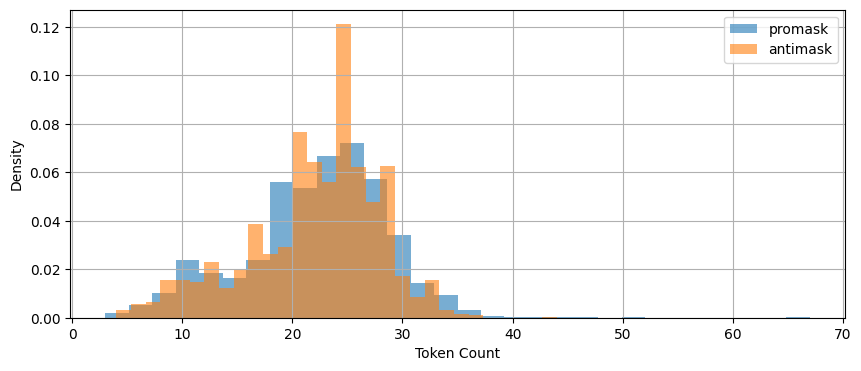

,count,mean,std,min,1%,5%,25%,50%,75%,95%,99%,max
group,,,,,,,,,,,,
antimask,2069.0,21.899952,5.977403,4.0,6.0,10.0,19.0,23.0,26.0,30.0,33.0,44.0
promask,5000.0,22.209600,6.435336,3.0,7.0,10.0,18.0,23.0,27.0,31.0,35.0,67.0


In [ ]:
#| eval: false

fig, ax = plt.subplots(figsize=(10, 4))

for grp in ['promask', 'antimask']:
    df[df.group == grp]['token_count'].hist(
        bins=30,
        density=True,
        alpha=0.6,
        label=grp,
        ax=ax
    )

ax.legend()
ax.set_xlabel('Token Count')
ax.set_ylabel('Density')

plt.show()

df.groupby('group')['token_count'].describe(
    percentiles=[.01, .05, .25, .5, .75, .95, .99]
)


These are very similar. 

Both groups:
- exhibit right-skewed token count distributions
- have similar central tendencies

This is useful because differences in our observations will be unlikely due to document length.

It probably won't be practical to visualize all the words in our corpus, so let's start by showing the top 30 after filtering out stopwords, punctuation, numbers, and spaces.

It probably won't be practical to visualize all the words in our corpus, so let's start by showing the top 30 after filtering out stopwords, punctuation, numbers, and spaces.

The code below processes each tweet through spaCy, filters tokens to exclude stopwords, punctuation, numbers, and whitespace, counts the remaining tokens, and displays the top 30 most frequent words as horizontal bar charts for each group.

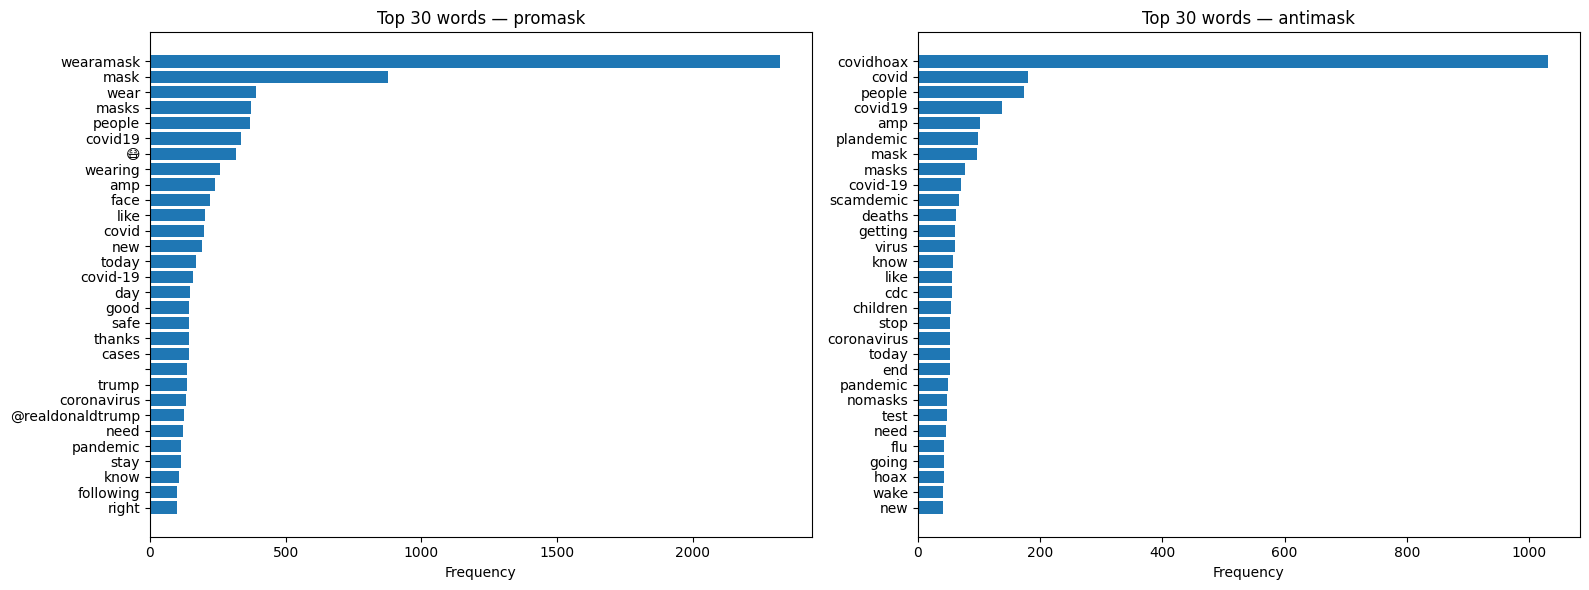

In [ ]:
#| eval: false

num_to_plot = 30
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

for ax, group in zip(axes, ['promask', 'antimask']):
    texts = df[df['group'] == group]['clean_text']
    word_counts = Counter()

    # batch processing with spaCy. nlp.pipe() is 10-50x faster
    # on real corpora. EDA on text is often bottlenecked by NLP
    # pipelines not analysis in pandas
    for doc in nlp.pipe(texts, batch_size=1000):
        for token in doc:
            if (
                not token.is_stop
                and not token.is_punct
                and not token.like_num
                and not token.is_space
            ):
                word_counts[token.text] += 1

    top_words = word_counts.most_common(num_to_plot)
    words, counts = zip(*top_words)

    ax.barh(words[::-1], counts[::-1])
    ax.set_xlabel('Frequency')
    ax.set_title(f'Top {num_to_plot} words — {group}')

plt.tight_layout()
plt.show()


#### Keyword-in-Context

The function below is known as a **"keyword in context" (KWIC)** visualization, or **concordance**. A concordance is a traditional corpus linguistics tool that displays all occurrences of a word along with its surrounding context, allowing analysts to see patterns in how words are actually used.

The **`kwic_spacy():`** function below works in three steps:
1. **Loop through texts** — For each tweet, create a spaCy Doc
2. **Find matches** — Loop through tokens, check if each matches the keyword (case-insensitive)
3. **Extract context** — When a match is found, grab *window* tokens before and after

The key is getting the context window so your keyword is lined up nicely with token context:

`doc[max(0, i-window):i]` — slice of tokens before the match (using max(0,...) to avoid negative indices)

`doc[i+1:i+1+window]` — slice of tokens after the match

The `:>40` in the f-string right-aligns the left context to 40 characters, so the keyword lines up nicely in a column.

In [ ]:
#| eval: false

def kwic_spacy(texts, keyword, window=5, n=20):
    results = []

    for doc in nlp.pipe(texts, batch_size=1000):
        for i, token in enumerate(doc):
            if token.text.lower() == keyword.lower():
                left = doc[max(0, i-window):i].text.replace('\n', ' ')
                right = doc[i+1:i+1+window].text.replace('\n', ' ')
                results.append(f"{left:>40} [{token.text}] {right}")

                if len(results) >= n:
                    return results

    return results


We've got a weird "amp" in our list. This looks suspiciously like poorly handled html codes. Let's explore that hypothesis with a quick concordance(key word in context or kwic) view.

In [ ]:
#| eval: false

nlp = get_nlp()
kwic_spacy(df['clean_text'],"amp")

✅ spaCy model 'en_core_web_sm' loaded successfully


["                ordered your semper fi & [amp] ; america's fund face",
 '                         on now. darcy & [amp] ; stacey. #darceyandstacey',
 '                     does not fit well & [amp] ; too much… https://t.co/oumpor5r0k',
 '              #staysafe #speakyourmind & [amp] ; #wearamask 😷 https://t.co/ml01hrikiz',
 '          : 25,378,371 confirmed cases & [amp] ; 850,163 deaths 90 countries',
 '                          if @ladygaga & [amp] ; her team can completely',
 '                     tweeps. take care & [amp] ; stay safe! #',
 '           good to see @usembassynepal & [amp] ; @usambnepal promoting #wearamask',
 '      @usambnepal promoting #wearamask & [amp] ; #maskchallenge even when',
 '          greg armstrong, epidemiology & [amp] ; cancer control.  ',
 '                         ariana grande & [amp] ; lady gaga  💜',
 '                   all over the states & [amp] ; continuing to spread…',
 '                      if @arianagrande & [amp] ; @ladygaga can do a',


To fix the "amp" issue (and other html artifacts), we could add this right after we created clean_text.

```
import html

df['clean_text'] = df['clean_text'].apply(html.unescape)
```

While kwic is very useful for analysis -- it's also handy for EDA!

#### Reflection

1. Why can a term be very frequent but still uninformative about group stance?
Give an example from the hashtag or emoji analyses.

2. What does dispersion tell you that raw frequency cannot?
In what situations would you trust dispersion more than frequency?

3. Choose one hashtag or emoji that appears in both groups.
Based on KWIC or examples, does it appear to serve the same communicative function in each group?

In [ ]:
q3_answer = "Give an example of a frequent but uninformative term about group stance."

In [ ]:
q4_answer = "What does dispersion tell you that raw frequency cannot?"

In [ ]:
q5_answer = "Hashtag or emoji.. Based on KWIC or examples, does it serve the same communicative function?"

## C - Distributional Patterns

Frequency alone is inadequate for revealing patterns of use. Let's look for high-frequency, low-dispersion terms. **Dispersion** measures how evenly or unevenly a word (or linguistic structure) is spread across different parts of a text corpus or dataset. Dispersion complements frequency by showing *where* observations occur rather than *how often*.

For example, a small number of users in our Twitter data could be responsible for boosting the frequency of specific terms. These could matter since they might reveal:
- Bot activity
- Coordinated messaging campaigns
- Copy-paste patterns
- Influential user amplification

**Distributional analysis** in NLP is a method that finds word meanings by analyzing their surrounding contexts. It gets at "patterns of use" rather than isolated metrics. We'll dig in much more deeply into distributional analysis because it is one of the most important concepts in both NLP and LLMs.

Let's look at hashtags. We can plot in a variety of ways, though for our purposes it would be fun to compare between groups.

Let's look at hashtags. We can plot in a variety of ways, though for our purposes it would be fun to compare between groups.

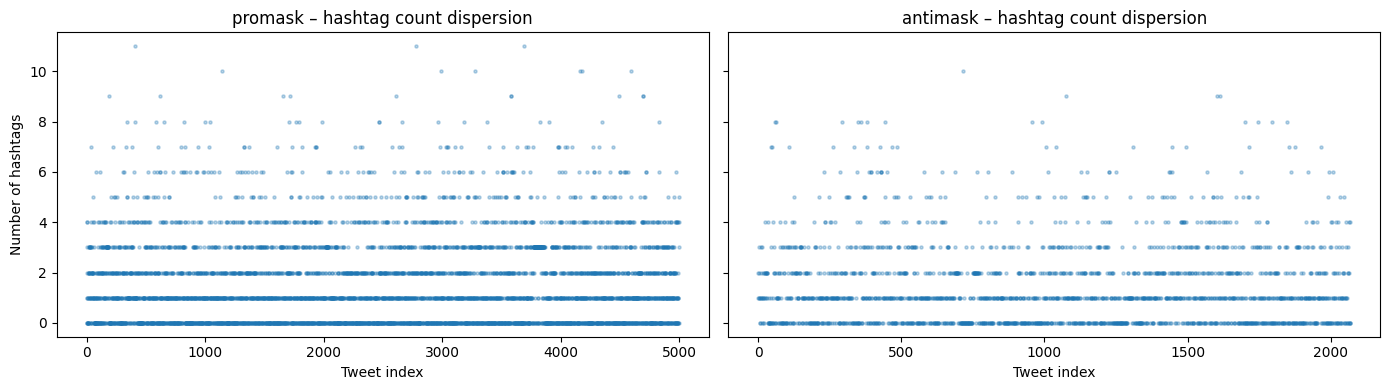

In [ ]:
#| eval: false

fig, axes = plt.subplots(1, 2, figsize=(14, 4), sharey=True)

for ax, group in zip(axes, ['promask', 'antimask']):
    subset = df[df['group'] == group].reset_index()

    ax.scatter(
        subset.index,
        subset['num_hashtags'],
        alpha=0.3,
        s=5
    )

    ax.set_xlabel('Tweet index')
    ax.set_title(f'{group} – hashtag count dispersion')

axes[0].set_ylabel('Number of hashtags')

plt.tight_layout()
plt.show()


This plot is about **dispersion**. It shows a dense cluster of 0-4 hashtags but with some sparse outliers in each group. 

It looks like it's common to have up to about 4 hashtags. What do samples containing 8 more more look like?

In [ ]:
#| eval: false

# Let's expand our display so we can see the entire tweet text
pd.set_option('display.max_colwidth', None)

In [ ]:
#| eval: false

# Inspect the extreme tail of the hashtag distribution (unusually hashtag-dense tweets)
df[df["num_hashtags"] >= 8][
    ["tweet_text", "num_hashtags", "group"]
].head(10)


,tweet_text,num_hashtags,group
193,#startup #healthcare #stayhome #staysafe #hopeforthebest #wearamask #washyourhands #protectyourself #protectothers… https://t.co/DGOFzacYD4,9,promask
342,#sundayinspiration got mask? \n.\n.\n.\n#gotmask #covid19nyc #covidharlem #pandemic #itsnotover #staysafer #wearamask… https://t.co/Wr24AO2sqq,8,promask
405,#Calling all #CoastlineCollege #students! Want a chance to #WIN #free #staycation #swag? Send us a #selfie wearing… https://t.co/bwDWdu2Eiq,8,promask
408,#quote #quoteoftheday #quotetoliveby #monday #inaworld #world #beanything #anything #bekind #kind #kindness… https://t.co/FRokelPXFL,11,promask
588,Mask up Washington 😷 \n.\n.\n.\n#maskup #maskupwashington #wearamask #wearyourmask #mask #selfie #maskselfie #hike… https://t.co/kv5QVJX4cp,8,promask
619,#sevenmile #sunday #wearamask l went with the #murdershewrote #jessicafletcher #angelalansbury #mask #NRC #NIKE… https://t.co/WMPfYNtBrG,9,promask
655,welcome to the Party #Nov3 #WearAMask #JoeBiden #VoteBlue #resist #CoronaVirus #NotMyPresident #VoteByMail… https://t.co/vuyCboZ1jV,8,promask
825,This is terrifying. #WearAMask #TakeCare #ByKind #Beach #BeachLife #Sunday #SundayFunDay #BeachMask https://t.co/4Vw3GnRzoz,8,promask
1004,#BidenHarris #BidenHarris2020 #NastyWoman #RidinWithBiden #NastyWomanForBiden #Masks #WearAMask #StopTheSpread… https://t.co/wemxjE0LQY,8,promask
1040,#sneezing with your #mask on feels like shitting your pants with your face! #funny #COVID19 #WearAMask #maskdebate #coronavirus #rona,8,promask


The hyperlinks in the tweet_text still link to X (Twitter). Can you look at some and guess which are real people and which aren't?

Let's play around with dispersions on other sorts of words!

In [ ]:
#| eval: false

# list some of the words we want to examine

pandemic_words =   ["pandemic", "CDC", "cure", "science", "vaccine", "virus", "guidelines", "mask", "masks", "FDA"]
conspiracy_words = ["plandemic", "scamdemic", "hoax"]
search_words = pandemic_words
moral_words = ["like", "love", "adore", "dislike", "hate", "abhor", "detest", "sickening"]
some_stopwords = ["for","a", "the", "and"]

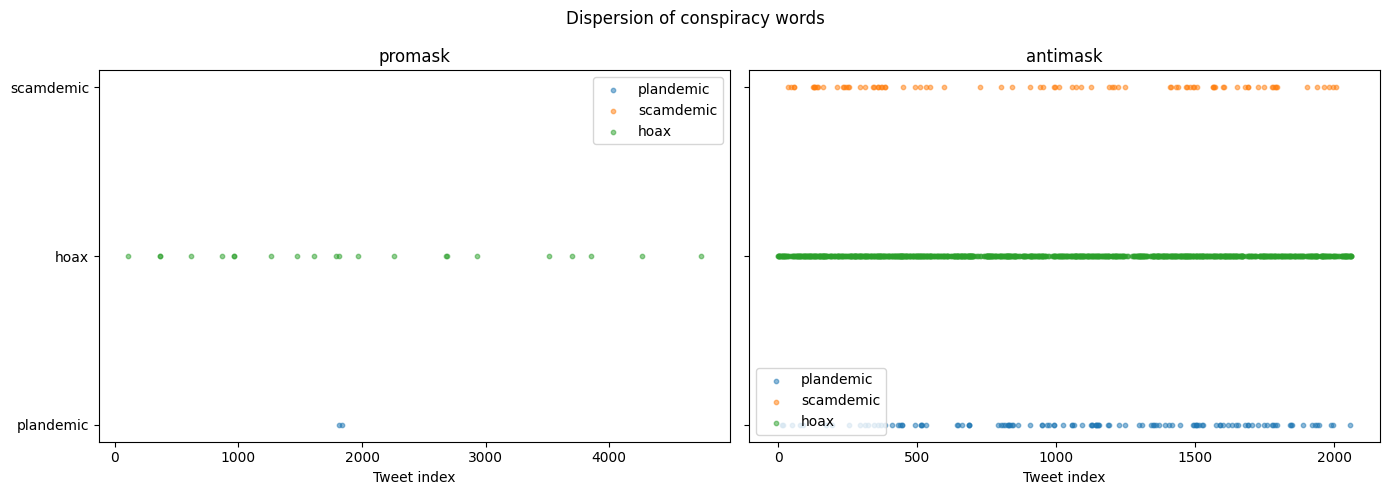

In [ ]:
#| eval: false

fig, axes = plt.subplots(1, 2, figsize=(14, 5), sharey=True)

for ax, group in zip(axes, ['promask', 'antimask']):
    subset = df[df['group'] == group]['clean_text'].reset_index(drop=True)

    for word in conspiracy_words:
        positions = [
            i for i, text in enumerate(subset)
            if word.lower() in text.lower()
        ]
        ax.scatter(
            positions,
            [word] * len(positions),
            alpha=0.5,
            s=10,
            label=word
        )

    ax.set_xlabel('Tweet index')
    ax.set_title(group)
    ax.legend()

plt.suptitle('Dispersion of conspiracy words')
plt.tight_layout()
plt.show()


This plot is very cool! It shows where words occur... not how often. Try some yourself!

In this section, you learned:
- **Dispersion** complements frequency by showing where words occur across a corpus, not just how often
- High frequency with low dispersion may indicate bot activity, coordinated campaigns, or copy-paste behavior
- **KWIC (Keyword in Context)** concordances let you inspect the actual usage contexts of words
- HTML artifacts (like `&amp;`) are common in web-scraped text and should be unescaped during preprocessing
- **Dispersion plots** visualize word occurrence across document indices, revealing clustering patterns
- Different word categories (pandemic terms, conspiracy terms, moral/emotional terms) show distinct distributional signatures across groups

The key insight is that *where* words appear can be as informative as *how often* they appear—distributional analysis is foundational to understanding meaning in both classical NLP and modern LLMs.

#### Reflection

- Two groups can have similar averages but very different distributions. What kinds of linguistic or social processes could produce that situation?

- What does dispersion reveal that frequency hides? In what scenario would dispersion be more trustworthy than frequency?

- What patterns in the dispersion plots might indicate coordinated behavior, automation, or amplification rather than organic language use?

In [ ]:
q6_answer = "Linguistic or social processes similar averages different distributions"

In [ ]:
q7_answer = "Scenario where dispersion is more trustworthy than frequency"

In [ ]:
q8_answer = "Pattern that might indicate a coordinated / automated behavior"

## D - Lexical Variety Through Lemmatization 

In Sections A and B, we analyzed surface tokens — what people literally typed.
In this section, we ask a different question: how much lexical variety exists once we collapse inflectional variants that express the same underlying word?

Lemmatization lets us approximate **semantic diversity** rather than **stylistic variation**.

Examples of lexical variation across word forms approximating the same meaning:

- mask, masks, masked, masking
- lie, lies, lying, lied
- die, dies, dying, died

Are these different ideas, or different realizations of the same idea?

What can we see if we lemmatize our data. Will we see a condensed semantic representation of discourse?

In [ ]:
#| eval: false

# Build spaCy Docs (again). We're using a batch size to to help normalize
nlp = get_nlp()

docs_promask = list(nlp.pipe(
    df[df["group"] == "promask"]["clean_text"],
    batch_size=1000
))

docs_antimask = list(nlp.pipe(
    df[df["group"] == "antimask"]["clean_text"],
    batch_size=1000
))


✅ spaCy model 'en_core_web_sm' loaded successfully


The function below iterates over spaCy docs (already lemmatized) and filters to "content" words. It keeps words that are alphabetic and not stopwords. It then stores them in a set so each lemma is counted once.

In [ ]:
#| eval: false

def get_unique_lemmas(docs):
    """
    Extract unique content-word lemmas from pre-parsed spaCy Docs.
    """
    lemmas = set()

    for doc in docs:
        for tok in doc:
            if (
                tok.is_alpha
                and not tok.is_stop
            ):
                lemmas.add(tok.lemma_.lower())

    return lemmas


Let's get unique lemmas for both promask and antimask, and also those that are shared.

In [ ]:
#| eval: false

promask_lemmas = get_unique_lemmas(docs_promask)
antimask_lemmas = get_unique_lemmas(docs_antimask)

unique_to_promask_lemmas = promask_lemmas - antimask_lemmas
unique_to_antimask_lemmas = antimask_lemmas - promask_lemmas
shared_lemmas = promask_lemmas & antimask_lemmas

(len(promask_lemmas), len(antimask_lemmas), len(shared_lemmas))

(8104, 3961, 2135)

Now let's count tokens using the same filters. We'll need this to calculate a lemma-to-token ratio.

In [ ]:
#| eval: false

def count_content_tokens(docs):
    total = 0
    for doc in docs:
        for tok in doc:
            if tok.is_alpha and not tok.is_stop:
                total += 1
    return total

promask_token_total = count_content_tokens(docs_promask)
antimask_token_total = count_content_tokens(docs_antimask)

In [ ]:
#| eval: false

# Lemma-to-token ratio (lexical variety)

lemma_token_ratios = {
    "promask": len(promask_lemmas) / promask_token_total,
    "antimask": len(antimask_lemmas) / antimask_token_total,
}

lemma_token_ratios


{'promask': 0.20993187058000673, 'antimask': 0.261296919321855}

The lemma-to-token ratio (LTR) is a way to quantify **lexical variety** after normalization for meaning. It answers a more precise question than raw vocabulary size.

Here's we're asking: *How many distinct underlying words are used per content word produced.*

We calculate: 

- Tokens as alphabetic, non-stopword tokens
- Lemmas as tokens collapsed to their base form (mask, not masks/masking/masked)

When we look at it here, it looks like antimask as a higher ratio of content words -- but we can't really say that because we have different dataset sizes for promask and antimask. We'd have to sample to compare more directly.

Now let's take a look at how overlapping lemmas are.

In [ ]:
#| eval: false

# Proportion of shared vs. group-specific lemmas

lemma_overlap_stats = {
    "shared_lemmas": len(shared_lemmas),
    "promask_unique": len(unique_to_promask_lemmas),
    "antimask_unique": len(unique_to_antimask_lemmas),
    "promask_total": len(promask_lemmas),
    "antimask_total": len(antimask_lemmas),
}

lemma_overlap_stats


{'shared_lemmas': 2135,
 'promask_unique': 5969,
 'antimask_unique': 1826,
 'promask_total': 8104,
 'antimask_total': 3961}

In [ ]:
#| eval: false

# Normalize to proportions

lemma_overlap_ratios = {
    "promask_shared_prop": len(shared_lemmas) / len(promask_lemmas),
    "antimask_shared_prop": len(shared_lemmas) / len(antimask_lemmas),
    "promask_unique_prop": len(unique_to_promask_lemmas) / len(promask_lemmas),
    "antimask_unique_prop": len(unique_to_antimask_lemmas) / len(antimask_lemmas),
}

lemma_overlap_ratios


{'promask_shared_prop': 0.2634501480750247,
 'antimask_shared_prop': 0.5390053016914921,
 'promask_unique_prop': 0.7365498519249754,
 'antimask_unique_prop': 0.460994698308508}

Let's put all of this together...

In [ ]:
#| eval: false

lemma_summary = pd.DataFrame.from_dict(
    {
        "promask": {
            "content_tokens": promask_token_total,
            "unique_lemmas": len(promask_lemmas),
            "lemma_token_ratio": len(promask_lemmas) / promask_token_total,
            "shared_lemma_prop": len(shared_lemmas) / len(promask_lemmas),
            "unique_lemma_prop": len(unique_to_promask_lemmas) / len(promask_lemmas),
        },
        "antimask": {
            "content_tokens": antimask_token_total,
            "unique_lemmas": len(antimask_lemmas),
            "lemma_token_ratio": len(antimask_lemmas) / antimask_token_total,
            "shared_lemma_prop": len(shared_lemmas) / len(antimask_lemmas),
            "unique_lemma_prop": len(unique_to_antimask_lemmas) / len(antimask_lemmas),
        },
    }
).T

lemma_summary


,content_tokens,unique_lemmas,lemma_token_ratio,shared_lemma_prop,unique_lemma_prop
promask,38603.0,8104.0,0.209932,0.263450,0.736550
antimask,15159.0,3961.0,0.261297,0.539005,0.460995


The table compares lexical variety after lemmatization between the pro-mask and anti-mask groups, controlling for stopwords and non-alphabetic tokens.

1. Corpus size vs. vocabulary size

- Pro-mask tweets contain many more content tokens overall.
- They also contain more unique lemmas in absolute terms.

But... a larger corpus naturally accumulates more distinct words. So this is not surprising.

2. Lemma–token ratio (lexical variety) - Anti-mask has a higher lemma-to-token ratio than pro-mask.

This could mean that anti-mask discourse discourse uses fewer total words, but those words are less repetitious. It seems pro-mask discourse repeats the same lemmas more often. With more effort and great attention to tokenization, you could dig deeper and derive some real insights.

Now let's look at lemmas! Are we seeing themes, clusters of conversation around particular institutions, people, emotions, etc?

In [ ]:
#| eval: false

from collections import Counter

def count_lemma_frequencies(docs, target_lemmas=None):
    """
    Count lemma frequencies in spaCy Docs.

    Parameters
    ----------
    docs : iterable of spacy.tokens.Doc
        Pre-parsed spaCy documents.
    target_lemmas : set[str] or None
        If provided, only lemmas in this set are counted.

    Returns
    -------
    Counter
        Mapping from lemma -> frequency.
    """
    counts = Counter()

    for doc in docs:
        for tok in doc:
            if (
                tok.is_alpha
                and not tok.is_stop
            ):
                lemma = tok.lemma_.lower()

                if target_lemmas is None or lemma in target_lemmas:
                    counts[lemma] += 1

    return counts


In [ ]:
#| eval: false

# Top 20 lemmas promask

promask_top20 = count_lemma_frequencies(
    docs_promask,
    unique_to_promask_lemmas
).most_common(20)


print("Top 20 Promask-unique lemmas:")
for lemma, count in promask_top20:
    print(f"{lemma:<20} {count}")


Top 20 Promask-unique lemmas:
stayathomesavelive   86
staysafe             74
washyourhand         71
cotton               68
morning              64
layer                49
sunday               45
stayhome             43
challenge            43
covidisreal          32
wash                 27
vma                  26
nominate             24
cont                 23
foot                 23
flower               23
gaga                 22
cool                 21
practice             21
art                  20


In [ ]:
#| eval: false

# Top 20 lemmas unique antimask

antimask_top20 = count_lemma_frequencies(
    docs_antimask,
    unique_to_antimask_lemmas
).most_common(20)

print("\nTop 20 Antimask-unique lemmas:")
for lemma, count in antimask_top20:
    print(f"{lemma:<20} {count}")



Top 20 Antimask-unique lemmas:
scamdemic            67
notomask             37
evid                 19
newspaper            18
bill                 16
awake                14
keepbritainfree      14
nwo                  13
quietly              12
entity               12
globalist            10
ableg                10
logical              10
cdnpoli              9
abpoli               9
legally              9
covidscam            8
standupx             8
fakepandemic         8
pcr                  8


In [ ]:
#| eval: false

# Count shared lemma frequencies per group
shared_promask = count_lemma_frequencies(
    docs_promask,
    target_lemmas=shared_lemmas
)

shared_antimask = count_lemma_frequencies(
    docs_antimask,
    target_lemmas=shared_lemmas
)

# Build comparison table
shared_df = (
    pd.DataFrame({
        "lemma": list(shared_lemmas),
        "promask_rate_per_1k": [
            shared_promask.get(l, 0) / promask_token_total * 1000
            for l in shared_lemmas
        ],
        "antimask_rate_per_1k": [
            shared_antimask.get(l, 0) / antimask_token_total * 1000
            for l in shared_lemmas
        ],
    })
    .assign(max_rate=lambda d: d[["promask_rate_per_1k", "antimask_rate_per_1k"]].max(axis=1))
    .sort_values("max_rate", ascending=False)
    .drop(columns="max_rate")
    .head(20)
)

shared_df


,lemma,promask_rate_per_1k,antimask_rate_per_1k
1670,covidhoax,0.025905,68.078369
2016,wearamask,60.176670,0.329837
2058,mask,32.717664,11.742199
259,wear,17.330259,4.815621
132,covid,5.129135,11.940102
550,people,9.532938,11.478330
192,amp,6.217133,6.662709
1087,plandemic,0.051809,6.530774
2124,test,1.347046,6.266904
1730,death,2.098283,6.134969


Lemmatization can reduce vocabulary size while preserving meaning, which directly affects model sparsity, generalization, and interpretability. That said, it's most useful if your focus on is on meaning such as **topic modeling**, **keyword extraction**, and **search**. It can also be helpful for bag-of-word ML classifiers such as logistic regression, naive bayes, and SVMs.

## Reflection 

1. Does lemmatization change your interpretation of lexical diversity compared to raw token counts?

2. Do you think lemmatization would help or hurt a stance classifier trained on this data? Why?

3. What did you find most interesting from this lab?
  
4. What did you find most surprising from this lab?

In [ ]:
q9_answer = "Does lemmatization change your interpretation of lexical diversity compared to raw token counts?"

In [ ]:
q10_answer = "Can you tell which group appears to rely more on repeated lexical items"

In [ ]:
q11_answer = "What did you find most interesting from this lab?"

In [ ]:
q12_answer = "What did you find most surprising from this lab?"

## Notebook Summary

- **Text preprocessing** involves many analytic decisions. Every decision affects downstream analyses such as vocabulary, frequency counts, and analyses. 
- **Raw frequency** is rarely informative on its own; normalization and relative measures are necessary to compare groups of different sizes meaningfully.
- **Dispersion** complements frequency by showing where language appears, helping distinguish widespread usage from repetition, coordination, or amplification.
- **Keyword-in-context (KWIC)** analysis grounds statistics in real language use, revealing how the same word can serve different functions across groups and exposing preprocessing artifacts.
- **Lemmatization** shifts analysis from surface form to meaning, reducing sparsity and enabling clearer comparisons of lexical variety and shared vs. group-specific vocabulary.
- **Lexical variety metrics** (e.g., lemma-to-token ratio) reveal differences in repetition and semantic breadth that are not visible in raw counts.

Multiple perspectives are essential: meaningful text analysis emerges from combining frequency, normalization, dispersion, and contextual inspection rather than relying on any single metric.

In [ ]:
# REVIEW ONLY — does not submit

from data401_nlp.helpers.submit import collect_answers, parse_answers, submit_answers

# REVIEW ONLY — does not submit

raw = collect_answers(
    show=True,
    namespace=globals(),  
)

answers = parse_answers(raw)

print(f"\nDetected {len(answers)} answers:")
for k in answers:
    print(" ", k)

=== Student Responses (from variable state) ===

q12_answer = 'What did you find most surprising from this lab?'

Detected 1 answers:
  q12_answer


In [ ]:
#| eval: false

ALLOW_SUBMISSION = False   # ← student MUST change this

def submit_for_credit(student_id):
    if not ALLOW_SUBMISSION:
        raise RuntimeError(
            "⚠️ Submission is disabled.\n\n"
            "To submit:\n"
            "  1. Set ALLOW_SUBMISSION = True\n"
            "  2. Re-run this cell"
        )

    submit_answers(
        student_id=student_id,
        answers=answers,   # uses reviewed answers
    )

    print("✅ Submission complete.")

In [ ]:
#| eval: false
# ✏️ EDIT WITH YOUR STUDENT ID
submit_for_credit("test_student")

RuntimeError: ⚠️ Submission is disabled.

To submit:
  1. Set ALLOW_SUBMISSION = True
  2. Re-run this cell